# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [365]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [366]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [367]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [368]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


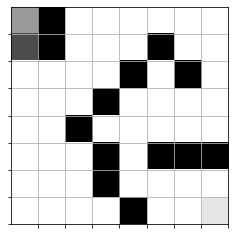

In [369]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [370]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [371]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [372]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [373]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # pseudocode:
    # For each epoch:
    for i in range(n_epoch):
        print('Epoch ', i)
    #    Agent_cell = randomly select a free cell
        Agent_cell = random.choice(qmaze.free_cells)
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
        qmaze.reset(Agent_cell)
        envstate = qmaze.observe()
        loss = 0
        n_episodes = 0
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
        envstate = qmaze.observe()
        
        game_status = 'not_over'
    #    While state is not game over:
        while game_status=='not_over':
    #        previous_envstate = envstate
            prev_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
            action = random.choice(qmaze.valid_actions())
    #        envstate, reward, game_status = qmaze.act(action)
    #        Hint: Review the act method in the TreasureMaze.py class.
            envstate, reward, game_status = qmaze.act(action)
    #        episode = [previous_envstate, action, reward, envstate, game_status]
            n_episodes += 1
            episode = [prev_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #        Hint: Review the remember method in the GameExperience.py class.
            experience.remember(episode)
    #        Train neural network model and evaluate loss
    #        Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
            inputs, targets = experience.get_data()
            model.fit(inputs, targets, epochs=8, batch_size=24, verbose=0)
            losss = model.evaluate(inputs, targets)
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.
        if win_rate > 0.9 and completion_check(model, qmaze):
            epoch = i
            print(i)

    
    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(n_epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

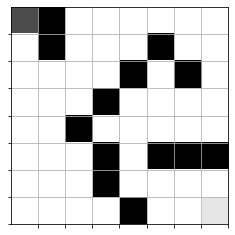

In [374]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [375]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch  0
10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 7.7 seconds
Epoch  1
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 13.3 seconds
Epoch  2
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 18.7 seconds
Epoch  3
10/10 [==============================] - 0s 56us/step


10/10 [==============================] - 0s 0us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 24.3 seconds
Epoch  4
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 162 | Win count: 0 | Win rate: 0.000 | time: 30.4 seconds
Epoch  5
10/10 [==============================] - 0s 105us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 35.3 seconds
Epoch  6
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 40.7 seconds
Epoch  7
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 46.3 seconds
Epoch  8
10/10 [==============================] - 0s 62us/step


10/10 [==============================] - 0s 111us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 51.6 seconds
Epoch  9
10/10 [==============================] - 0s 480us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 9 | Win count: 0 | Win rate: 0.000 | time: 51.9 seconds
Epoch  10
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 57.3 seconds
Epoch  11
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 108us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 0 | Win rate: 0.000 | time: 58.2 seconds
Epoch  12
10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 86 | Win count: 0 | Win rate: 0.000 | time: 61.3 seconds
Epoch  13
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 367us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 66.7 seconds
Epoch  14
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 50us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 82 | Win count: 0 | Win rate: 0.000 | time: 69.6 seconds
Epoch  15
10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 112us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 75.1 seconds
Epoch  16
10/10 [==============================] - 0s 48us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 152 | Win count: 0 | Win rate: 0.000 | time: 80.7 seconds
Epoch  17
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 86.2 seconds
Epoch  18
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 158 | Win count: 0 | Win rate: 0.000 | time: 92.0 seconds
Epoch  19
10/10 [==============================] - 0s 46us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 97.4 seconds
Epoch  20
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 153 | Win count: 0 | Win rate: 0.000 | time: 103.1 seconds
Epoch  21
10/10 [==============================] - 0s 60us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 164 | Win count: 0 | Win rate: 0.000 | time: 109.3 seconds
Epoch  22
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 114.4 seconds
Epoch  23
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 119.7 seconds
Epoch  24
10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 1 | Win count: 0 | Win rate: 0.000 | time: 119.7 seconds
Epoch  25
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 125.1 seconds
Epoch  26
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 154 | Win count: 0 | Win rate: 0.000 | time: 131.0 seconds
Epoch  27
10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 136.6 seconds
Epoch  28
10/10 [==============================] - 0s 157us/step


10/10 [==============================] - 0s 104us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 163 | Win count: 0 | Win rate: 0.000 | time: 142.5 seconds
Epoch  29
10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 147.5 seconds
Epoch  30
10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 108us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 152.5 seconds
Epoch  31
10/10 [==============================] - 0s 102us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 1 | Win count: 0 | Win rate: 0.000 | time: 152.6 seconds
Epoch  32
10/10 [==============================] - 0s 327us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 157.9 seconds
Epoch  33
10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 163.0 seconds
Epoch  34
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 270us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 168.3 seconds
Epoch  35
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 106us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 146 | Win count: 0 | Win rate: 0.000 | time: 173.5 seconds
Epoch  36
10/10 [==============================] - 0s 208us/step


10/10 [==============================] - 0s 160us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 178.7 seconds
Epoch  37
10/10 [==============================] - 0s 104us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 2 | Win count: 0 | Win rate: 0.000 | time: 178.8 seconds
Epoch  38
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 153 | Win count: 0 | Win rate: 0.000 | time: 184.6 seconds
Epoch  39
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 105us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 190.0 seconds
Epoch  40
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 195.5 seconds
Epoch  41
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 55us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 121 | Win count: 0 | Win rate: 0.000 | time: 199.8 seconds
Epoch  42
10/10 [==============================] - 0s 430us/step


10/10 [==============================] - 0s 99us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 205.0 seconds
Epoch  43
10/10 [==============================] - 0s 0us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 210.5 seconds
Epoch  44
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 0us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 216.6 seconds
Epoch  45
10/10 [==============================] - 0s 114us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 120 | Win count: 0 | Win rate: 0.000 | time: 221.2 seconds
Epoch  46
10/10 [==============================] - 0s 59us/step


10/10 [==============================] - 0s 188us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 227.5 seconds
Epoch  47
10/10 [==============================] - 0s 175us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 93 | Win count: 0 | Win rate: 0.000 | time: 231.5 seconds
Epoch  48
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 152us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 236.9 seconds
Epoch  49
10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 45 | Win count: 0 | Win rate: 0.000 | time: 238.4 seconds
Epoch  50
10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 103us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 243.9 seconds
Epoch  51
10/10 [==============================] - 0s 61us/step


10/10 [==============================] - 0s 50us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 248.8 seconds
Epoch  52
10/10 [==============================] - 0s 55us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 254.5 seconds
Epoch  53
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 260.0 seconds
Epoch  54
10/10 [==============================] - 0s 163us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 13 | Win count: 0 | Win rate: 0.000 | time: 260.5 seconds
Epoch  55
10/10 [==============================] - 0s 211us/step


10/10 [==============================] - 0s 59us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 266.3 seconds
Epoch  56
10/10 [==============================] - 0s 60us/step


10/10 [==============================] - 0s 61us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 152 | Win count: 0 | Win rate: 0.000 | time: 272.1 seconds
Epoch  57
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 277.3 seconds
Epoch  58
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 278us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 283.3 seconds
Epoch  59
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 1ms/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 288.4 seconds
Epoch  60
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 105us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 154 | Win count: 0 | Win rate: 0.000 | time: 294.2 seconds
Epoch  61
10/10 [==============================] - 0s 104us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 13 | Win count: 0 | Win rate: 0.000 | time: 294.7 seconds
Epoch  62
10/10 [==============================] - 0s 146us/step


10/10 [==============================] - 0s 116us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 67 | Win count: 0 | Win rate: 0.000 | time: 297.1 seconds
Epoch  63
10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 9 | Win count: 0 | Win rate: 0.000 | time: 297.4 seconds
Epoch  64
10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 7 | Win count: 0 | Win rate: 0.000 | time: 297.6 seconds
Epoch  65
10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 303.0 seconds
Epoch  66
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 308.2 seconds
Epoch  67
10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 141us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 313.6 seconds
Epoch  68
10/10 [==============================] - 0s 155us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 5 | Win count: 0 | Win rate: 0.000 | time: 313.8 seconds
Epoch  69
10/10 [==============================] - 0s 176us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 319.7 seconds
Epoch  70
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 156us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 154 | Win count: 0 | Win rate: 0.000 | time: 325.6 seconds
Epoch  71
10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 1 | Win count: 0 | Win rate: 0.000 | time: 325.7 seconds
Epoch  72
10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 3 | Win count: 0 | Win rate: 0.000 | time: 325.8 seconds
Epoch  73
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 331.4 seconds
Epoch  74
10/10 [==============================] - 0s 112us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 336.7 seconds
Epoch  75
10/10 [==============================] - 0s 56us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 125 | Win count: 0 | Win rate: 0.000 | time: 341.5 seconds
Epoch  76
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 50us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 346.9 seconds
Epoch  77
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 352.7 seconds
Epoch  78
10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 108us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 156 | Win count: 0 | Win rate: 0.000 | time: 358.4 seconds
Epoch  79
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 107us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 363.7 seconds
Epoch  80
10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 64us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 369.7 seconds
Epoch  81
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 212us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 375.1 seconds
Epoch  82
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 221us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 160 | Win count: 0 | Win rate: 0.000 | time: 381.2 seconds
Epoch  83
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 158 | Win count: 0 | Win rate: 0.000 | time: 387.4 seconds
Epoch  84
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 105us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 124 | Win count: 0 | Win rate: 0.000 | time: 392.0 seconds
Epoch  85
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 397.1 seconds
Epoch  86
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 225us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 6.70 minutes
Epoch  87
10/10 [==============================] - 0s 113us/step


10/10 [==============================] - 0s 48us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 154 | Win count: 0 | Win rate: 0.000 | time: 6.80 minutes
Epoch  88
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 6.88 minutes
Epoch  89
10/10 [==============================] - 0s 107us/step


10/10 [==============================] - 0s 106us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 6.97 minutes
Epoch  90
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 56us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 7.05 minutes
Epoch  91
10/10 [==============================] - 0s 145us/step


10/10 [==============================] - 0s 49us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 152 | Win count: 0 | Win rate: 0.000 | time: 7.15 minutes
Epoch  92
10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 21 | Win count: 0 | Win rate: 0.000 | time: 7.16 minutes
Epoch  93
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 7.25 minutes
Epoch  94
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 152 | Win count: 0 | Win rate: 0.000 | time: 7.35 minutes
Epoch  95
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 102us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 7.43 minutes
Epoch  96
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 7.53 minutes
Epoch  97
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 114us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 7.62 minutes
Epoch  98
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 7.72 minutes
Epoch  99
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 176us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 7.82 minutes
Epoch  100
10/10 [==============================] - 0s 284us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 64 | Win count: 0 | Win rate: 0.000 | time: 7.85 minutes
Epoch  101
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 50us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 7.94 minutes
Epoch  102
10/10 [==============================] - 0s 110us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 3 | Win count: 0 | Win rate: 0.000 | time: 7.94 minutes
Epoch  103
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 488us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 8.04 minutes
Epoch  104
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 71 | Win count: 0 | Win rate: 0.000 | time: 8.08 minutes
Epoch  105
10/10 [==============================] - 0s 187us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 3 | Win count: 0 | Win rate: 0.000 | time: 8.08 minutes
Epoch  106
10/10 [==============================] - 0s 0us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 9 | Win count: 0 | Win rate: 0.000 | time: 8.09 minutes
Epoch  107
10/10 [==============================] - 0s 104us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 4 | Win count: 0 | Win rate: 0.000 | time: 8.09 minutes
Epoch  108
10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 2 | Win count: 0 | Win rate: 0.000 | time: 8.09 minutes
Epoch  109
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 55us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 8.18 minutes
Epoch  110
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 123us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 8.27 minutes
Epoch  111
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 135 | Win count: 0 | Win rate: 0.000 | time: 8.36 minutes
Epoch  112
10/10 [==============================] - 0s 137us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 8.47 minutes
Epoch  113
10/10 [==============================] - 0s 371us/step


10/10 [==============================] - 0s 111us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 8.57 minutes
Epoch  114
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 106us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 8.69 minutes
Epoch  115
10/10 [==============================] - 0s 109us/step


10/10 [==============================] - 0s 161us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 166 | Win count: 0 | Win rate: 0.000 | time: 8.82 minutes
Epoch  116
10/10 [==============================] - 0s 106us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 85 | Win count: 0 | Win rate: 0.000 | time: 8.88 minutes
Epoch  117
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 9.00 minutes
Epoch  118
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 9.12 minutes
Epoch  119
10/10 [==============================] - 0s 553us/step


10/10 [==============================] - 0s 62us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 153 | Win count: 0 | Win rate: 0.000 | time: 9.22 minutes
Epoch  120
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 9.33 minutes
Epoch  121
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 9.44 minutes
Epoch  122
10/10 [==============================] - 0s 55us/step


10/10 [==============================] - 0s 107us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 53 | Win count: 0 | Win rate: 0.000 | time: 9.47 minutes
Epoch  123
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 9.57 minutes
Epoch  124
10/10 [==============================] - 0s 0us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 146 | Win count: 0 | Win rate: 0.000 | time: 9.66 minutes
Epoch  125


10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 154 | Win count: 0 | Win rate: 0.000 | time: 9.76 minutes
Epoch  126
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 107us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 9.87 minutes
Epoch  127
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 49us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 9.97 minutes
Epoch  128
10/10 [==============================] - 0s 268us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 152 | Win count: 0 | Win rate: 0.000 | time: 10.07 minutes
Epoch  129
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 161 | Win count: 0 | Win rate: 0.000 | time: 10.18 minutes
Epoch  130
10/10 [==============================] - 0s 450us/step


10/10 [==============================] - 0s 209us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 159 | Win count: 0 | Win rate: 0.000 | time: 10.28 minutes
Epoch  131
10/10 [==============================] - 0s 56us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 10.38 minutes
Epoch  132
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 10.47 minutes
Epoch  133
10/10 [==============================] - 0s 104us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 41 | Win count: 0 | Win rate: 0.000 | time: 10.50 minutes
Epoch  134
10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 55us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 10.60 minutes
Epoch  135
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 106us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 10.70 minutes
Epoch  136
10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 250us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 10.80 minutes
Epoch  137
10/10 [==============================] - 0s 109us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 7 | Win count: 0 | Win rate: 0.000 | time: 10.80 minutes
Epoch  138
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 106us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 10.90 minutes
Epoch  139
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 11.00 minutes
Epoch  140
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 11.10 minutes
Epoch  141
10/10 [==============================] - 0s 107us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 11.20 minutes
Epoch  142
10/10 [==============================] - 0s 158us/step


10/10 [==============================] - 0s 431us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 11.30 minutes
Epoch  143
10/10 [==============================] - 0s 212us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 35 | Win count: 0 | Win rate: 0.000 | time: 11.33 minutes
Epoch  144
10/10 [==============================] - 0s 73us/step


10/10 [==============================] - 0s 0us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 154 | Win count: 0 | Win rate: 0.000 | time: 11.43 minutes
Epoch  145
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 11.52 minutes
Epoch  146
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 107us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 11.62 minutes
Epoch  147
10/10 [==============================] - 0s 62us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 11.72 minutes
Epoch  148
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 11.81 minutes
Epoch  149
10/10 [==============================] - 0s 107us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 11.91 minutes
Epoch  150
10/10 [==============================] - 0s 110us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 2 | Win count: 0 | Win rate: 0.000 | time: 11.91 minutes
Epoch  151
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 109us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 12.00 minutes
Epoch  152
10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 0 | Win rate: 0.000 | time: 12.01 minutes
Epoch  153
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 146 | Win count: 0 | Win rate: 0.000 | time: 12.11 minutes
Epoch  154
10/10 [==============================] - 0s 37us/step


10/10 [==============================] - 0s 0us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 12.21 minutes
Epoch  155
10/10 [==============================] - 0s 139us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 12.31 minutes
Epoch  156
10/10 [==============================] - 0s 110us/step


10/10 [==============================] - 0s 104us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 12.40 minutes
Epoch  157
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 58us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 12.50 minutes
Epoch  158
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 12.58 minutes
Epoch  159
10/10 [==============================] - 0s 61us/step


10/10 [==============================] - 0s 152us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 12.67 minutes
Epoch  160
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 50us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 12.77 minutes
Epoch  161
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 154 | Win count: 0 | Win rate: 0.000 | time: 12.87 minutes
Epoch  162
10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 12.96 minutes
Epoch  163
10/10 [==============================] - 0s 55us/step


10/10 [==============================] - 0s 113us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 63 | Win count: 0 | Win rate: 0.000 | time: 13.00 minutes
Epoch  164
10/10 [==============================] - 0s 192us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 13.09 minutes
Epoch  165
10/10 [==============================] - 0s 157us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 57 | Win count: 0 | Win rate: 0.000 | time: 13.12 minutes
Epoch  166
10/10 [==============================] - 0s 107us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 11 | Win count: 0 | Win rate: 0.000 | time: 13.13 minutes
Epoch  167
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 55us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 13.22 minutes
Epoch  168
10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 121 | Win count: 0 | Win rate: 0.000 | time: 13.29 minutes
Epoch  169
10/10 [==============================] - 0s 112us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 88 | Win count: 0 | Win rate: 0.000 | time: 13.34 minutes
Epoch  170
10/10 [==============================] - 0s 368us/step


10/10 [==============================] - 0s 106us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 13.43 minutes
Epoch  171
10/10 [==============================] - 0s 277us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 2 | Win count: 0 | Win rate: 0.000 | time: 13.43 minutes
Epoch  172
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 58us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 13.52 minutes
Epoch  173
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 54us/step


Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 13.62 minutes
Epoch  174
10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 13.71 minutes
Epoch  175
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 13.80 minutes
Epoch  176
10/10 [==============================] - 0s 44us/step


Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 6 | Win count: 0 | Win rate: 0.000 | time: 13.80 minutes
Epoch  177
10/10 [==============================] - 0s 107us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 129 | Win count: 0 | Win rate: 0.000 | time: 13.88 minutes
Epoch  178
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 154 | Win count: 0 | Win rate: 0.000 | time: 13.97 minutes
Epoch  179
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 103us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 14.07 minutes
Epoch  180
10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 6 | Win count: 0 | Win rate: 0.000 | time: 14.07 minutes
Epoch  181
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 19 | Win count: 0 | Win rate: 0.000 | time: 14.08 minutes
Epoch  182
10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 10 | Win count: 0 | Win rate: 0.000 | time: 14.09 minutes
Epoch  183
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 55us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 14.17 minutes
Epoch  184
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 14.26 minutes
Epoch  185
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 146 | Win count: 0 | Win rate: 0.000 | time: 14.37 minutes
Epoch  186
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 105us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 14.47 minutes
Epoch  187
10/10 [==============================] - 0s 108us/step


10/10 [==============================] - 0s 104us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 14.56 minutes
Epoch  188
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 53us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 14.65 minutes
Epoch  189
10/10 [==============================] - 0s 50us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 11 | Win count: 0 | Win rate: 0.000 | time: 14.66 minutes
Epoch  190
10/10 [==============================] - 0s 243us/step


10/10 [==============================] - 0s 60us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 14.75 minutes
Epoch  191
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 14.84 minutes
Epoch  192
10/10 [==============================] - 0s 55us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 72 | Win count: 0 | Win rate: 0.000 | time: 14.89 minutes
Epoch  193
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 104us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 14.97 minutes
Epoch  194
10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 109us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 146 | Win count: 0 | Win rate: 0.000 | time: 15.06 minutes
Epoch  195
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 106us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 152 | Win count: 0 | Win rate: 0.000 | time: 15.15 minutes
Epoch  196
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 107us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 63 | Win count: 0 | Win rate: 0.000 | time: 15.20 minutes
Epoch  197
10/10 [==============================] - 0s 92us/step


10/10 [==============================] - 0s 55us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 162 | Win count: 0 | Win rate: 0.000 | time: 15.30 minutes
Epoch  198
10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 6 | Win count: 0 | Win rate: 0.000 | time: 15.30 minutes
Epoch  199
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 62us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 15.39 minutes
Epoch  200
10/10 [==============================] - 0s 55us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 15.48 minutes
Epoch  201
10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 125 | Win count: 0 | Win rate: 0.000 | time: 15.56 minutes
Epoch  202
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 0us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 15.65 minutes
Epoch  203
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 81 | Win count: 0 | Win rate: 0.000 | time: 15.70 minutes
Epoch  204
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 59us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 15.78 minutes
Epoch  205
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 153 | Win count: 0 | Win rate: 0.000 | time: 15.87 minutes
Epoch  206
10/10 [==============================] - 0s 105us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 22 | Win count: 0 | Win rate: 0.000 | time: 15.88 minutes
Epoch  207
10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 10 | Win count: 0 | Win rate: 0.000 | time: 15.89 minutes
Epoch  208
10/10 [==============================] - 0s 158us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 5 | Win count: 0 | Win rate: 0.000 | time: 15.89 minutes
Epoch  209
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 51us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 146 | Win count: 0 | Win rate: 0.000 | time: 15.98 minutes
Epoch  210
10/10 [==============================] - 0s 108us/step


10/10 [==============================] - 0s 67us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 16.07 minutes
Epoch  211
10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 22 | Win count: 0 | Win rate: 0.000 | time: 16.08 minutes
Epoch  212
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 154 | Win count: 0 | Win rate: 0.000 | time: 16.18 minutes
Epoch  213
10/10 [==============================] - 0s 199us/step


10/10 [==============================] - 0s 54us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 16.27 minutes
Epoch  214
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 16.36 minutes
Epoch  215
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 105us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 98 | Win count: 0 | Win rate: 0.000 | time: 16.42 minutes
Epoch  216
10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 57 | Win count: 0 | Win rate: 0.000 | time: 16.45 minutes
Epoch  217
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 249us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 16.55 minutes
Epoch  218
10/10 [==============================] - 0s 1ms/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 18 | Win count: 0 | Win rate: 0.000 | time: 16.56 minutes
Epoch  219
10/10 [==============================] - 0s 127us/step


10/10 [==============================] - 0s 52us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 119 | Win count: 0 | Win rate: 0.000 | time: 16.64 minutes
Epoch  220
10/10 [==============================] - 0s 153us/step


10/10 [==============================] - 0s 3ms/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 16.75 minutes
Epoch  221
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 105us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 16.83 minutes
Epoch  222
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 56us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 16.93 minutes
Epoch  223
10/10 [==============================] - 0s 120us/step


10/10 [==============================] - 0s 89us/step
Epoch: 15000/14999 | Loss: 0.0000 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 17.02 minutes
Epoch  224
10/10 [==============================] - 0s 58us/step


10/10 [==============================] - 0s 51us/step


KeyboardInterrupt: 

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [ ]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

In [ ]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.